- Repetir toda a análise feita para o German Credit, porém para o Drug200 (drugC = 1, o resto = 0)

In [28]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score

# ignorar warnings (opcional)
warnings.filterwarnings('ignore')

In [2]:
# conectar o colab ao Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# lendo os dados
PATH = '/content/drive/MyDrive/Bootcamp_DataScience/AlgoritmosInteligenciaArtificialClassificacao/datasets/drug200.csv'
data = pd.read_csv(PATH)
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
# analisar a tipagem dos dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


<Axes: >

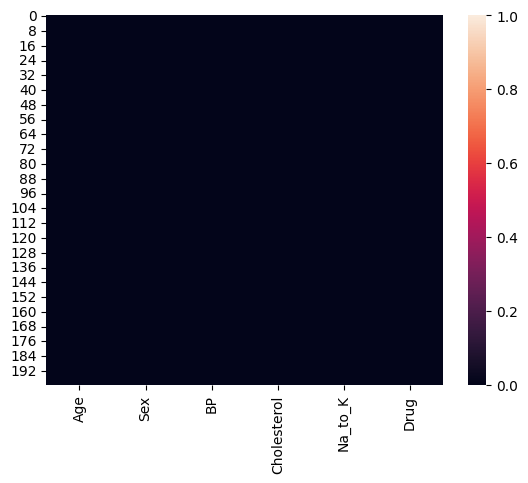

In [5]:
# analise de dados nulos
sns.heatmap(data.isna(), vmin=0, vmax=1)

In [6]:
# (opcional) modificar os nomes das colunas
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
data.head(1)

,age,sex,bp,cholesterol,na_to_k,drug
0,23,F,HIGH,HIGH,25.355,DrugY


In [7]:
# transformar o dataset para classificação binária - drugC = 1 / 0 caso contrário
data['drug'] = data['drug'].apply(lambda x: 1 if x == 'drugC' else 0)
data.head()

,age,sex,bp,cholesterol,na_to_k,drug
0,23,F,HIGH,HIGH,25.355,0
1,47,M,LOW,HIGH,13.093,1
2,47,M,LOW,HIGH,10.114,1
3,28,F,NORMAL,HIGH,7.798,0
4,61,F,LOW,HIGH,18.043,0


In [8]:
# verificar o balanceamento das classes
data['drug'].value_counts(normalize=True)

,proportion
drug,
0,0.92
1,0.08


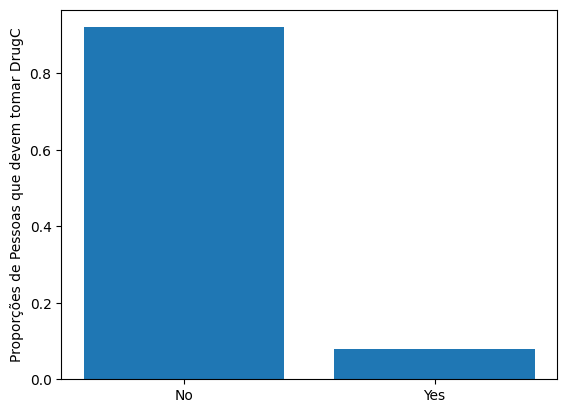

In [9]:
# outra forma de ver o balanceamento de classes
proportions = data['drug'].value_counts(normalize=True)

plt.bar(x=proportions.index, height=proportions.values)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.ylabel('Proporções de Pessoas que devem tomar DrugC')
plt.show()

In [11]:
# para iniciar - apenas variáveis numéricas (reais)
data = data[['drug', 'age', 'na_to_k']]
data.head()

,drug,age,na_to_k
0,0,23,25.355
1,1,47,13.093
2,1,47,10.114
3,0,28,7.798
4,0,61,18.043


In [12]:
# outra forma de verificar tamanho dos dados
data.shape

(200, 3)

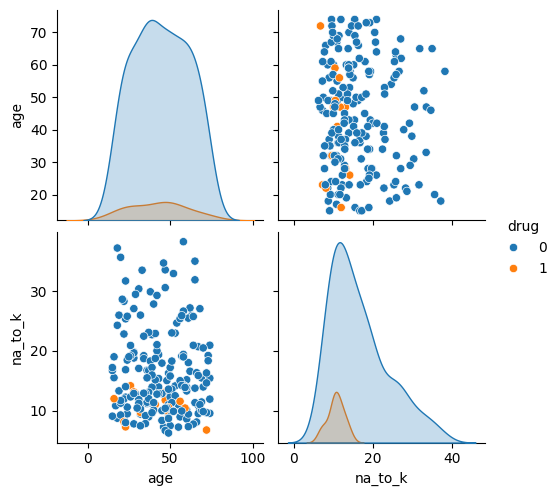

In [13]:
# analise de separabilide linear (visual)
sns.pairplot(data, hue='drug')

In [14]:
# separando x e y
x = data.drop(columns=['drug'])
y = data[['drug']]

In [15]:
# separação treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

In [16]:
# analise de proporções
props = pd.DataFrame(y.value_counts(normalize=True).values, columns=['original'])
props['train'] = y_train.value_counts(normalize=True).values
props['test'] = y_test.value_counts(normalize=True).values
props

,original,train,test
0,0.92,0.921429,0.916667
1,0.08,0.078571,0.083333


In [17]:
# criar um modelo baseline - hipótese: todos não devem tomar a drugC (todos = 0)
y_base = np.repeat(0, repeats=y_test.shape[0])
y_base

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
# métricas do baseline
print(classification_report(y_test, y_base))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        55
           1       0.00      0.00      0.00         5

    accuracy                           0.92        60
   macro avg       0.46      0.50      0.48        60
weighted avg       0.84      0.92      0.88        60



In [19]:
# criar um primeiro modelo de regressão Logística
rl1 = LogisticRegression(penalty=None).fit(x_train, y_train)

# fazendo a previsão do teste
yhat_rl1 = rl1.predict(x_test)

# analisando métricas
print(classification_report(y_test, yhat_rl1))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        55
           1       0.00      0.00      0.00         5

    accuracy                           0.92        60
   macro avg       0.46      0.50      0.48        60
weighted avg       0.84      0.92      0.88        60



- Testar as métricas de outras formas de escalonamento


In [20]:
# criar um pipeline de modelagem
rl2_pr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', LogisticRegression(penalty=None))
])
rl2_norm = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LogisticRegression(penalty=None))
])
rl2_p = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(penalty=None))
])

# ajustando o pipeline
rl2_pr.fit(x_train, y_train)
rl2_norm.fit(x_train, y_train)
rl2_p.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(penalty=None))])

In [21]:
# fazer novas previsões
yhat_rl2_pr = rl2_pr.predict(x_test)
yhat_rl2_norm = rl2_norm.predict(x_test)
yhat_rl2_p = rl2_p.predict(x_test)

# analisar as métricas
print('Métricas do Modelo com Padronização Robusta')
print(classification_report(y_test, yhat_rl2_pr))
print()

print('Métricas do Modelo com Normalização')
print(classification_report(y_test, yhat_rl2_norm))
print()

print('Métricas do Modelo com Padronização')
print(classification_report(y_test, yhat_rl2_p))
print()

Métricas do Modelo com Padronização Robusta
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        55
           1       0.00      0.00      0.00         5

    accuracy                           0.92        60
   macro avg       0.46      0.50      0.48        60
weighted avg       0.84      0.92      0.88        60


Métricas do Modelo com Normalização
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        55
           1       0.00      0.00      0.00         5

    accuracy                           0.92        60
   macro avg       0.46      0.50      0.48        60
weighted avg       0.84      0.92      0.88        60


Métricas do Modelo com Padronização
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        55
           1       0.00      0.00      0.00         5

    accuracy                           0.92        60
   macro a

- Para o drug200, adotar as seguintes métricas:
 - TP = 100 (a pessoa acertou o remédio que deve tomar e não usou o plano de saúde)
 - FP = -150 (a pessoa errou o remédio e teve de ir ao PS)
 - TN = 100 (a pessoa acertou que não era para tomar o rmédio C e não usou o plano de saúde)
 - FN = -250 (a pessoa deveria tomar o C, mas não tomou, e por isso teve de usar a UTI)

In [23]:
def profit(yreal, ypred):
  # calcular a matrix de confusão
  cm = confusion_matrix(yreal, ypred)

  # extrair as pontuações
  tp = cm[1, 1] # verdadeiros positivos
  fp = cm[0, 1] # falsos positivos
  tn = cm[0, 0] # verdadeiros negativos
  fn = cm[1, 0] # falsos negativos

  # lucro total
  lucro = (100 * tp) + (-250 * fn) + (100 * tn) + (-150 * fp)

  # retornar o lucro médio por cliente
  return lucro / yreal.shape[0]

In [24]:
print(f'Lucro Médio - modelo baseline: ', profit(y_test, y_base))
print(f'Lucro Médio - modelo RL1: ', profit(y_test, yhat_rl1))
print(f'Lucro Médio - modelo RL2 - Padronização Robusta: ', profit(y_test, yhat_rl2_pr))
print(f'Lucro Médio - modelo RL2 - Normalização: ', profit(y_test, yhat_rl2_norm))
print(f'Lucro Médio - modelo RL2 - Padronização: ', profit(y_test, yhat_rl2_p))

Lucro Médio - modelo baseline:  70.83333333333333
Lucro Médio - modelo RL1:  70.83333333333333
Lucro Médio - modelo RL2 - Padronização Robusta:  70.83333333333333
Lucro Médio - modelo RL2 - Normalização:  70.83333333333333
Lucro Médio - modelo RL2 - Padronização:  70.83333333333333


- realizar a análise de limiar para o drug200 (condições da aula 2)

In [26]:
# permitir seleção do modelo
model_set = {
    1: rl1,
    2: rl2_pr,
    3: rl2_norm,
    4: rl2_p
}

no = int(input('Digite o número do modelo desejado:\n1 - Modelo sem Escalonamento\n2 - Modelo Escalonado com Padronização Robusta\n3 - Modelo Escalonado com Normalização\n4 - Modelo Escalonado com Padronização\n\nModelo Desejado: '))

Digite o número do modelo desejado:
1 - Modelo sem Escalonamento
2 - Modelo Escalonado com Padronização Robusta
3 - Modelo Escalonado com Normalização
4 - Modelo Escalonado com Padronização

Modelo Desejado: 4


In [42]:
# selecionando o modelo
model = model_set.get(no)

In [43]:
# criando um vetor de probabilidades
prob_min = np.linspace(0.01, 0.99, 99)

# realizar as previsões das probabilidades de toda base de teste
prob_test = model.predict_proba(x_test)

FP = []
FN = []
precision = []
recall = []
avg_profit = []
for p in prob_min:

  # calcular o vetor de classes
  yhat = [1 if c[1] > p else 0 for c in prob_test]

  # calcular a matriz de confusão
  mc = confusion_matrix(y_test, yhat)

  # adiciono nas listas
  FP.append(mc[0, 1] / y_test.shape[0])
  FN.append(mc[1, 0] / y_test.shape[0])
  precision.append(precision_score(y_test, yhat))
  recall.append(recall_score(y_test, yhat))
  avg_profit.append(profit(y_test, yhat))

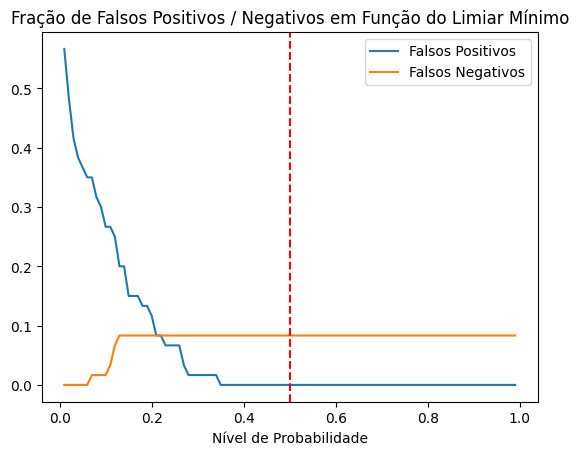

In [30]:
plt.plot(prob_min, FP, label='Falsos Positivos')
plt.plot(prob_min, FN, label='Falsos Negativos')
plt.title('Fração de Falsos Positivos / Negativos em Função do Limiar Mínimo')
plt.xlabel('Nível de Probabilidade')
plt.axvline(x=0.5, ls='--', color='red')
plt.legend()
plt.show()

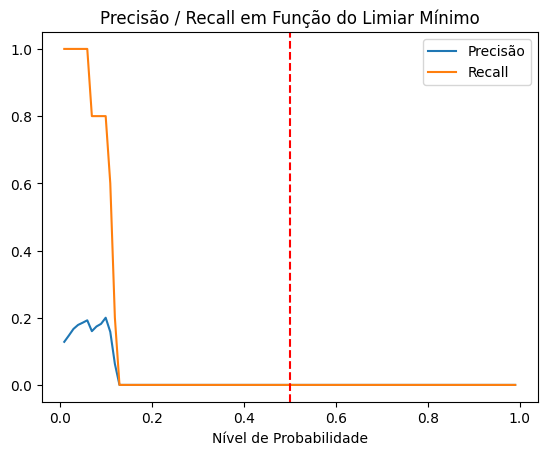

In [31]:
plt.plot(prob_min, precision, label='Precisão')
plt.plot(prob_min, recall, label='Recall')
plt.title('Precisão / Recall em Função do Limiar Mínimo')
plt.xlabel('Nível de Probabilidade')
plt.axvline(x=0.5, ls='--', color='red')
plt.legend()
plt.show()

In [34]:
# avaliando a curva de recall e precisão - todos os modelos
results = {}
for model in model_set:
  results[model] = {}
  results[model]['probs'] = model_set[model].predict_proba(x_test)        # calculando as probabilidade
  results[model]['prob_1'] = [c[1] for c in  results[model]['probs']]    # extraindo as probabilidades de classe 1
  results[model]['precision'], results[model]['recall'], _ = precision_recall_curve(y_test, results[model]['prob_1'])
  results[model]['fpr'], results[model]['tpr'], _ = roc_curve(y_test, results[model]['prob_1'])
  results[model]['roc_auc_score'] = roc_auc_score(y_test, results[model]['prob_1'])

In [35]:
# verificando um exemplo de chave dos results
results[1]

{'probs': array([[8.56416376e-01, 1.43583624e-01],
        [9.86353533e-01, 1.36464666e-02],
        [9.99918505e-01, 8.14947798e-05],
        [9.94299943e-01, 5.70005681e-03],
        [9.94863211e-01, 5.13678906e-03],
        [9.66344308e-01, 3.36556918e-02],
        [9.56640609e-01, 4.33593908e-02],
        [9.77024818e-01, 2.29751816e-02],
        [8.74179724e-01, 1.25820276e-01],
        [7.96901747e-01, 2.03098253e-01],
        [9.99884909e-01, 1.15091125e-04],
        [9.97128200e-01, 2.87179984e-03],
        [8.87169208e-01, 1.12830792e-01],
        [9.99525629e-01, 4.74370970e-04],
        [9.72613158e-01, 2.73868419e-02],
        [9.29967142e-01, 7.00328585e-02],
        [9.96493940e-01, 3.50606008e-03],
        [9.99550645e-01, 4.49354942e-04],
        [9.98875616e-01, 1.12438446e-03],
        [8.72741098e-01, 1.27258902e-01],
        [7.76125897e-01, 2.23874103e-01],
        [8.80544389e-01, 1.19455611e-01],
        [9.13570608e-01, 8.64293923e-02],
        [8.52709502e-01, 

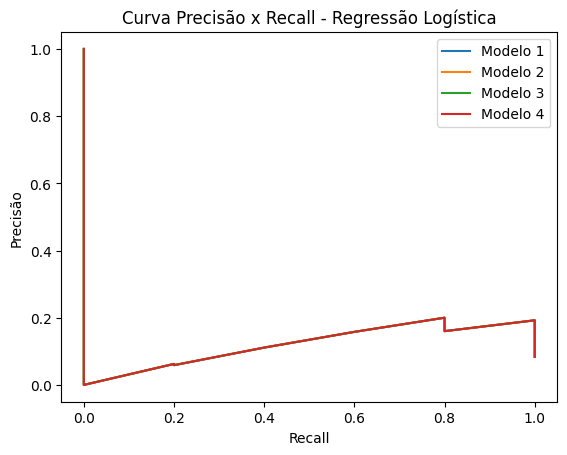

In [37]:
for model in results:
  plt.plot(results[model]['recall'], results[model]['precision'], label = f'Modelo {model}')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precisão x Recall - Regressão Logística')
plt.legend()
plt.show()

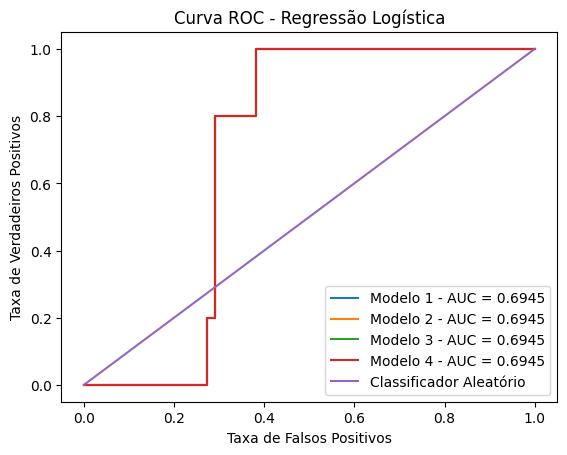

In [40]:
for model in results:
  plt.plot(results[model]['fpr'], results[model]['tpr'], label = f'Modelo {model} - AUC = {round(results[model]["roc_auc_score"], 4)}')
plt.plot([0, 1], [0, 1], label='Classificador Aleatório')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Regressão Logística')
plt.legend()
plt.show()

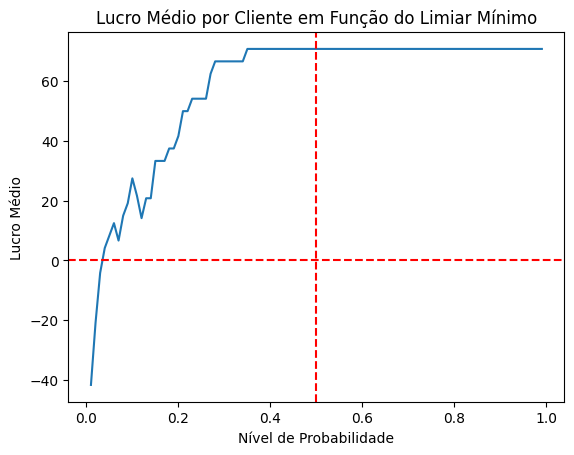

In [44]:
plt.plot(prob_min, avg_profit, label='Lucro Médio')
plt.ylabel('Lucro Médio')
plt.xlabel('Nível de Probabilidade')
plt.title('Lucro Médio por Cliente em Função do Limiar Mínimo')
plt.axhline(y=0, color='red', ls='--')
plt.axvline(x=0.5, color='red', ls='--')
plt.show()

- determinar programaticamente o ponto de operação (lucro médio máximo) - para o Drug200

In [48]:
# ponto de break-even (lucro = 0)
profit_lower_equal_zero = prob_min[np.array(avg_profit) <= 0]

print('Break-Even ocorre quando o limiar é (no mínimo): ', np.max(profit_lower_equal_zero))

Break-Even ocorre quando o limiar é (no mínimo):  0.03


In [54]:
# ponto de operação
max_profit = np.max(avg_profit)

# tomando o índice onde o lucro médio se iguala ao máximo
max_avg_profit = np.where(avg_profit == max_profit)[0][0]

# verificando o limiar
max_avg_profit_limit = prob_min[max_avg_profit]

print('O ponto de operação (Lucro Médio Máximo) é no limiar: ', max_avg_profit_limit)
print('Nesse ponto, o Lucro Médio vale: ', max_profit)

O ponto de operação (Lucro Médio Máximo) é no limiar:  0.35000000000000003
Nesse ponto, o Lucro Médio vale:  70.83333333333333
